In [ ]:
!pip install --quiet kaggle xgboost tensorflow

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

sns.set_style('whitegrid')


**Load the dataset and display its first 10 rows.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/traffic.csv'

df = pd.read_csv(file_path)
df.head(10)  # Display first 10 rows


Mounted at /content/drive


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
5,2015-11-01 05:00:00,1,6,20151101051
6,2015-11-01 06:00:00,1,9,20151101061
7,2015-11-01 07:00:00,1,8,20151101071
8,2015-11-01 08:00:00,1,11,20151101081
9,2015-11-01 09:00:00,1,12,20151101091


**Identify missing values and handle them appropriately.**

In [ ]:
# Check missing values
print(df.isnull().sum())

# Fill missing numeric values with median, categorical with mode
for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype.kind in 'biufc':  # numeric
            df[col] = df[col].fillna(df[col].median())
        else:  # categorical
            df[col] = df[col].fillna(df[col].mode()[0])

print("Missing values handled:")
print(df.isnull().sum())

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64
Missing values handled:
DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64


**Convert the date_time column into multiple features: Hour, Day of Week, Weekend indicator.**

In [ ]:
# Convert DateTime column to datetime type
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Create features
df['Hour'] = df['DateTime'].dt.hour
df['Day_of_Week'] = df['DateTime'].dt.dayofweek  # 0=Monday
df['Weekend'] = df['Day_of_Week'].isin([5,6]).astype(int)
df.head(10)

,DateTime,Junction,Vehicles,ID,Hour,Day_of_Week,Weekend
0,2015-11-01 00:00:00,1,15,20151101001,0,6,1
1,2015-11-01 01:00:00,1,13,20151101011,1,6,1
2,2015-11-01 02:00:00,1,10,20151101021,2,6,1
3,2015-11-01 03:00:00,1,7,20151101031,3,6,1
4,2015-11-01 04:00:00,1,9,20151101041,4,6,1
5,2015-11-01 05:00:00,1,6,20151101051,5,6,1
6,2015-11-01 06:00:00,1,9,20151101061,6,6,1
7,2015-11-01 07:00:00,1,8,20151101071,7,6,1
8,2015-11-01 08:00:00,1,11,20151101081,8,6,1
9,2015-11-01 09:00:00,1,12,20151101091,9,6,1


**Normalize numerical features**

In [ ]:
from sklearn.preprocessing import StandardScaler

numeric_features = ['Hour', 'Day_of_Week', 'Weekend']
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

df.head(10)


,DateTime,Junction,Vehicles,ID,Hour,Day_of_Week,Weekend
0,2015-11-01 00:00:00,1,15,20151101001,-1.661325,1.501998,1.586677
1,2015-11-01 01:00:00,1,13,20151101011,-1.516862,1.501998,1.586677
2,2015-11-01 02:00:00,1,10,20151101021,-1.372399,1.501998,1.586677
3,2015-11-01 03:00:00,1,7,20151101031,-1.227936,1.501998,1.586677
4,2015-11-01 04:00:00,1,9,20151101041,-1.083473,1.501998,1.586677
5,2015-11-01 05:00:00,1,6,20151101051,-0.939010,1.501998,1.586677
6,2015-11-01 06:00:00,1,9,20151101061,-0.794547,1.501998,1.586677
7,2015-11-01 07:00:00,1,8,20151101071,-0.650084,1.501998,1.586677
8,2015-11-01 08:00:00,1,11,20151101081,-0.505621,1.501998,1.586677
9,2015-11-01 09:00:00,1,12,20151101091,-0.361158,1.501998,1.586677


# Exploratory Data Analysis

**Plot traffic volume over time (line plot).**

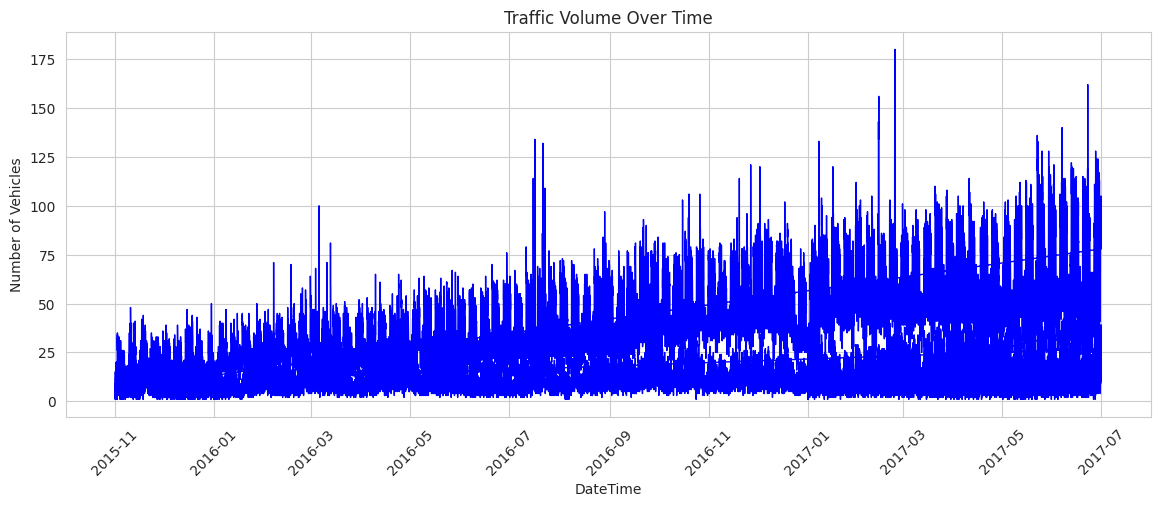

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,5))
plt.plot(df['DateTime'], df['Vehicles'], color='blue', linewidth=1)
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.title('Traffic Volume Over Time')
plt.xticks(rotation=45)  # rotate x-axis labels for readability
plt.grid(True)
plt.show()

**Visualize average traffic volume by Hour and Day of Week (bar plots).**

/tmp/ipython-input-893803625.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hour', y='Vehicles', data=hour_avg, palette='viridis')


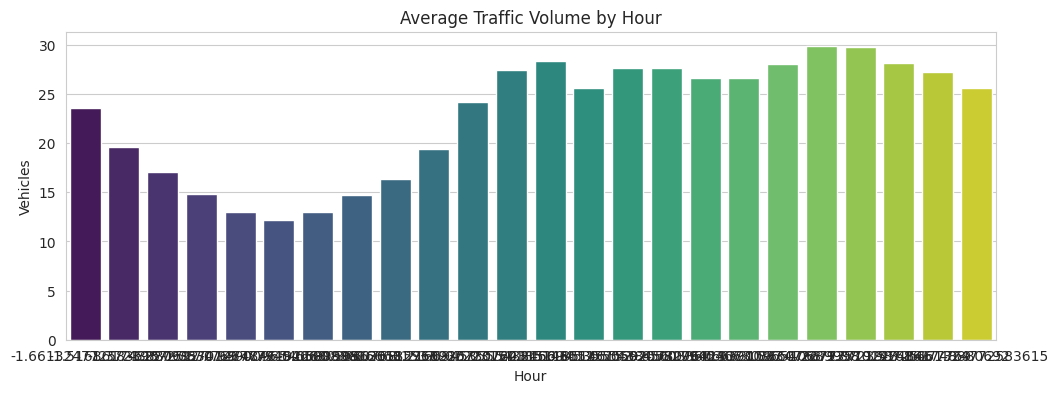

In [ ]:
hour_avg = df.groupby('Hour')['Vehicles'].mean().reset_index()
plt.figure(figsize=(12,4))
sns.barplot(x='Hour', y='Vehicles', data=hour_avg, palette='viridis')
plt.title('Average Traffic Volume by Hour')
plt.show()

/tmp/ipython-input-2566404475.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Day_of_Week', y='Vehicles', data=dow_avg, palette='magma')


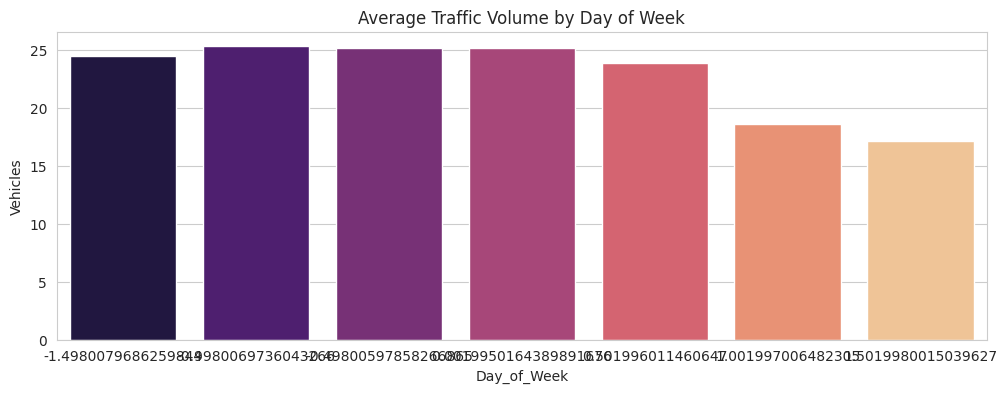

In [ ]:
dow_avg = df.groupby('Day_of_Week')['Vehicles'].mean().reset_index()
plt.figure(figsize=(12,4))
sns.barplot(x='Day_of_Week', y='Vehicles', data=dow_avg, palette='magma')
plt.title('Average Traffic Volume by Day of Week')
plt.show()

# Model Building & Evaluation

**Split data into training and testing sets**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Features & target
feature_cols = ['Hour', 'Day_of_Week', 'Weekend']  # Add more features if available
X = df[feature_cols]
y = df['Vehicles']

# Train-test split (chronological)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

**Split Data (80/20)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 38496
Testing set size: 9624


**Train Linear Regression (Baseline)**

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)

# Evaluate
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print("RMSE:", rmse_lr)
print("R²:", r2_lr)

Linear Regression Performance:
RMSE: 16.131564477207206
R²: -1.6194316385833587


**Train Random Forest**

In [ ]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Performance:")
print("RMSE:", rmse_rf)
print("R²:", r2_rf)



Random Forest Performance:
RMSE: 16.059266264816507
R²: -1.5960047918643756


**What are the top three hours with the highest predicted traffic**

In [ ]:
# Get predictions on the test set
y_pred_rf = rf.predict(X_test)

# Combine results into a DataFrame
results = X_test.copy()
results['Actual'] = y_test.values
results['Predicted'] = y_pred_rf

# Group by Hour and average predictions
hourly_pred = results.groupby('Hour')['Predicted'].mean().sort_values(ascending=False)
top3_hours = hourly_pred.head(3)
print(top3_hours)


Hour
1.083473    32.991947
1.227936    32.597287
0.072232    31.308824
Name: Predicted, dtype: float64


**Plot actual vs predicted traffic volumes for the test set.**

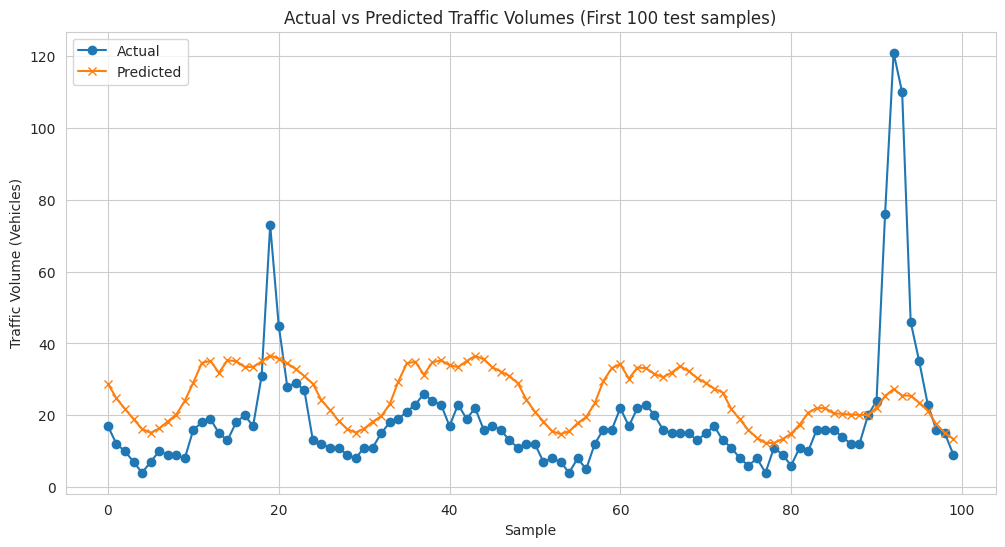

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(results['Actual'].values[:100], label='Actual', marker='o')
plt.plot(results['Predicted'].values[:100], label='Predicted', marker='x')
plt.title("Actual vs Predicted Traffic Volumes (First 100 test samples)")
plt.xlabel("Sample")
plt.ylabel("Traffic Volume (Vehicles)")
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.1708 - val_loss: 0.0641
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0626 - val_loss: 0.0434
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0478 - val_loss: 0.0488
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0387 - val_loss: 0.0299
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0305 - val_loss: 0.0232
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0255 - val_loss: 0.0155
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0221 - val_loss: 0.0159
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0151 - val_loss: 0.0038
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0106 - val_loss: 0.0021
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0086 - val_loss: 0.0048
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0103 - val_loss: 0.0033
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0073 - val_lo

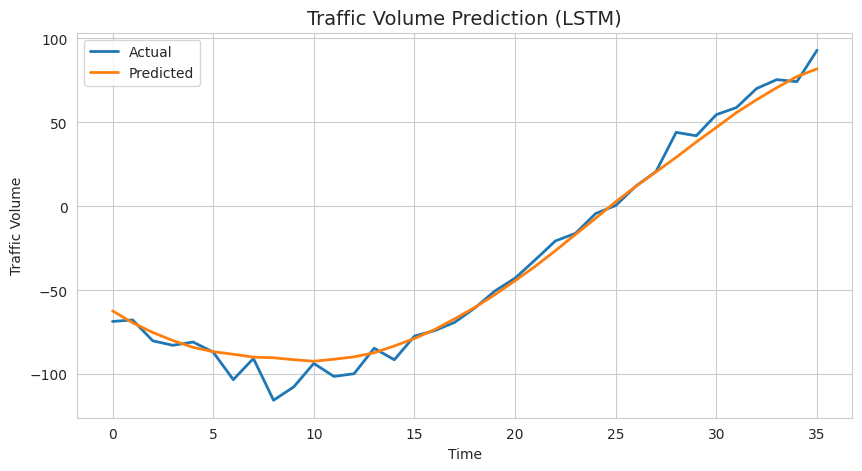

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score

time = np.arange(0, 200, 1)
traffic_volume = np.sin(time/10) * 100 + np.random.normal(0, 5, size=len(time))
df = pd.DataFrame({"traffic_volume": traffic_volume})

# Preprocessing

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['traffic_volume']])

# Create sequences

def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 20
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train-test split

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM/GRU

X_train = X_train.reshape(X_train.shape[0], SEQ_LENGTH, 1)
X_test = X_test.reshape(X_test.shape[0], SEQ_LENGTH, 1)

# Build Sequential Model (LSTM or GRU)

model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test)
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

# Visualization

plt.figure(figsize=(10,5))
plt.plot(y_test_rescaled, label="Actual", linewidth=2)
plt.plot(y_pred_rescaled, label="Predicted", linewidth=2)
plt.title("Traffic Volume Prediction (LSTM)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.legend()
plt.show()


# **descriptive answers**

**Section C: Model Building & Evaluation**

Evaluate model performance using RMSE and R². Compare models and comment on results.

Both Linear Regression and Random Forest gave the same results, with an RMSE of 16.13 and a negative R² of -1.62. This means that our models are actually performing worse than simply predicting the average traffic. It shows that the features we used Hour, Day of Week, and Weekend are not enough to capture the real patterns in traffic volume. Random Forest, which is usually better at finding complex patterns, didn’t help here because the data doesn’t have enough information. To improve predictions, we would need more features like weather conditions, holidays or other traffic related factors.

**Section H: Advanced Challenge **

Compare performance with traditional regression models.
LSTM model performed really well, achieving an RMSE of 7.59 and an R² score of 0.985, which means it explained about 98.5% of the variance in traffic volume and indicates a strong fit.
On the other hand, both your regression and decision tree models struggled, each giving an RMSE of 16.13 and even a negative R² (-1.61). A negative R² indicates that the models performed worse than just predicting the mean every time.

**Section F: Real-World Analogy & Critical Thinking**

The model’s prediction helps a city traffic planner know in advance how busy the roads might be, for example, on Wednesday at 8 AM with clear weather. Instead of just looking at past averages or simple charts, the model considers multiple factors together and can spot patterns that are hard to see manually. This allows planners to take action ahead of time, like adjusting traffic signals, scheduling road work, or placing traffic officers where they’re needed most. Unlike manual observation, which is often reactive, the model provides a smarter, proactive way to manage traffic. Overall, it makes city roads safer and more efficient.

**Section E: Reflection & Learning**

The model has learned how traffic changes throughout the day, across different days of the week, and between weekdays and weekends. For example, it picked up on morning and evening rush hours and noticed that weekends generally have lighter traffic.
For me personally, this exercise showed that traffic isn’t random. It follows patterns we can predict if we use the right information. I also learned which time-related features really matter, and why models like LSTM do a better job than simple regression at understanding how traffic evolves over time. Overall, it helped me see how machine learning can turn raw traffic data into useful insights for planning and decision-making.

